# Exploratory data analysis in retinal bipolar data with autoencoders

In this notebook, we will build a neural network that explores the retinal bipolar dataset for Shekhar et al., 2016 without using the manually annotated cell type labels.

## 1. Imports

In [ ]:
!pip install --user scprep

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import scprep

/usr/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or '1type' as a synonym of 

## 2. Loading the retinal bipolar data

We'll use the same retinal bipolar data you saw in preprocessing and visualization.

In [2]:
scprep.io.download.download_google_drive("1kxsMav1ly_S6pQ1vKeAtlFFW3QVvilz0", "shekhar_data.pkl")
scprep.io.download.download_google_drive("1J4K8bo8Pys-8xayO5vtMK3t5wJ0_TG2Y", "shekhar_clusters.pkl")

In [3]:
data = pd.read_pickle("shekhar_data.pkl")
clusters = pd.read_pickle("shekhar_clusters.pkl")

In [4]:
data = scprep.reduce.pca(data, n_components=100, method='dense').to_numpy()
labels, cluster_names = pd.factorize(clusters['CELLTYPE'])

## 3. Building an autoencoder

#### Create a `Session`

You only have to do this once.

In [15]:
sess = tf.InteractiveSession()

/usr/lib/python3.7/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
# this function applies the simple feedforward operation
def layer(x, n_dim, name, activation=None):
    # create the weight matrix
    W = tf.get_variable(dtype=tf.float32, shape=[x.get_shape()[-1], n_dim], name='W{}'.format(name))
    # create the bias vector
    b = tf.get_variable(dtype=tf.float32, shape=[n_dim], name='b{}'.format(name))
    # X2 = X1 * W + b
    output = tf.matmul(x, W) + b
    if activation:
        # nonlinear activation function
        output = activation(output)
    return output

batch_size = 100
data_tf = tf.placeholder(shape=[None, data.shape[1]], dtype=tf.float32, name='data_tf')


# layers will be input -> 100 -> 2 --> 100 -> output
hidden_layer1_tf = layer(data_tf, 100, 'hidden_layer1', activation=tf.nn.relu)
hidden_layer2_tf = layer(hidden_layer1_tf, 2, 'hidden_layer2', activation=None)
hidden_layer3_tf = layer(hidden_layer2_tf, 100, 'hidden_layer3', activation=tf.nn.relu)
output_tf = layer(hidden_layer3_tf, data.shape[1], 'output_tf', activation=None)


# use mean-squared-error reconstruction loss
loss_tf = tf.reduce_mean((data_tf - output_tf)**2)

# this part is all the same as before
learning_rate = .001
opt = tf.train.AdamOptimizer(learning_rate)

train_op = opt.minimize(loss_tf)

sess.run(tf.global_variables_initializer())

#### Train the network

In [7]:
step = 0
for epoch in range(10):
    random_order = np.random.permutation(data.shape[0])
    data_randomized = data[random_order]

    for data_batch in np.array_split(data_randomized, data_randomized.shape[0] // batch_size):
        step += 1
        
        if step % 100 == 0:
            loss_np = sess.run(loss_tf, {data_tf: data_batch})
            print("Step: {} Loss: {:.3f}".format(step, loss_np))

        sess.run(train_op, {data_tf: data_batch})

Step: 100 Loss: 7.881
Step: 200 Loss: 7.050
Step: 300 Loss: 6.927
Step: 400 Loss: 6.681
Step: 500 Loss: 6.240
Step: 600 Loss: 6.525
Step: 700 Loss: 6.417
Step: 800 Loss: 6.513
Step: 900 Loss: 6.134
Step: 1000 Loss: 5.772
Step: 1100 Loss: 6.000
Step: 1200 Loss: 6.112
Step: 1300 Loss: 5.864
Step: 1400 Loss: 6.082
Step: 1500 Loss: 6.009
Step: 1600 Loss: 5.651
Step: 1700 Loss: 6.066
Step: 1800 Loss: 6.477


#### Visualize the output

Rather than evaluating our model with our data like we did with the classifier, we can now use our model to evaluate our data (aka exploratory data analysis)!

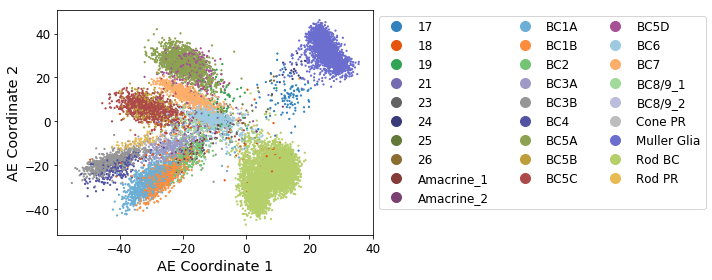

In [14]:
# let's get the 2D internal hidden layer and visualize it with a scatter plot
ae_coordinates = sess.run(hidden_layer2_tf, {data_tf: data})

scprep.plot.scatter2d(ae_coordinates, c=cluster_names[labels],
                      label_prefix='AE Coordinate ', discrete=True,
                      legend_anchor=(1,1), figsize=(10,4))

### Discussion

What do you notice about the visualization? How does this compare to the visualizations you saw on Wednesday with PCA, t-SNE, UMAP and PHATE?

#### _Breakpoint_  - once you get here, please help those around you!

## Exercise 4 - Activation functions on the visualization layer

Notice we used `activation=None` for the hidden layer we were going to visualize repeat the process with other activation functions like `tf.nn.relu`, `tf.nn.sigmoid`, `tf.nn.tanh`, etc. You can see more in the [Tensorflow documentation](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/keras/activations). 

Note how the visualization changes. Has the data changed at all?

In [ ]:
# ===================
# Copy the code from above and change `activation` in `hidden_layer2_tf` from `None` to one of the other options

# ===================

#### _Breakpoint_  - once you get here, please help those around you!

## Exercise 5 - Activation functions on the wide hidden layers

Now turn the activation for the visualization layer back to None, but experiment with the activation function for the 100-dimensional layers.

Is there a change? Why?

In [ ]:
# ===================
# Copy the code from above and change `activation` in `hidden_layer1_tf` and 
# `hidden_layer3_tf` from `None` to one of the other options

# ===================